## This notebook has been productionized in /Shared_Functionality/Preprocessing Functions, see audio_functions.npy and preprocess_functions.npy

It is evident that the preprocessing pipeline I've used for the audio is broken, I've decided to redo it and this file will be the testing ground for building that function

This preprocessing function will follow the heuristic laid out in the seq-2-seq piano transcription model 

In [3]:
from pathlib import Path
import numpy as np
import librosa, librosa.display

song_path = r'/Users/ewaissbluth/Documents/GitHub/tensor-hero/Training Data/Training Data/Unprocessed/Angevil Hero II/1. Andy McKee - Ouray/song.ogg'

data, sr = librosa.load(song_path)

In [4]:
resampled = librosa.resample(data, sr, 44100)

spec = librosa.feature.melspectrogram(resampled, 44100, n_fft=2048*2, hop_length=441, n_mels=512, power=2, fmax = sr/2)
spec = librosa.power_to_db(spec, ref=np.max)
print(spec.shape)

(512, 13917)


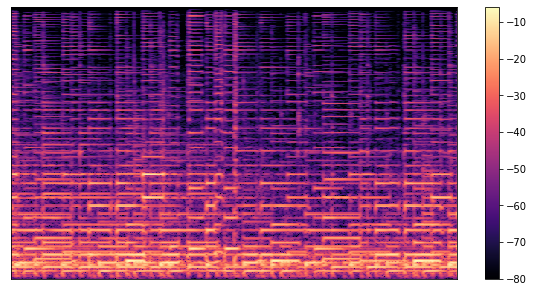

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
librosa.display.specshow(spec[:, 10000:10600])
plt.colorbar()

In [8]:
import os
from tqdm import tqdm
# Parse through training data
def check_multiple_audio_files(fileList):
    '''Checks if there are separate audio files for single song'''

    # Get audio file list
    num_files = 0
    multiple_files = False
    for track in fileList:
        if track.endswith('.ogg'):
            num_files += 1
        if track.endswith('.mp3'):
            num_files += 1
        if track.endswith('.wav'):
            num_files += 1
    if num_files > 1:
        multiple_files = True
    return multiple_files

# First, generate list of .ogg files, and a corresponding list of save directories
def get_list_of_ogg_files(unprocessed_path):
    '''
    Takes the root directory (unprocessed_path) and returns a list of the full file paths
    to all the .ogg files in that directory, provided there is only one per folder (i.e. it
    skips folders that have source separated music files). Also returns processed_paths, the "processed"
    directory analog to each item in ogg_file_paths (just a path to the folder, not the files inside)

    ~~~~ INPUTS ~~~~
    -   unprocessed_path : path object or string to root unprocessed folder. probably ./Training Data/Unprocessed

    ~~~~ OUTPUTS ~~~~
    -   ogg_file_paths : list of path objects to all .ogg files in unprocessed_path
    -   processed_paths : list of path objects to the processed folders corresponding to every item
                          in ogg_file_paths.  
    '''
    ogg_file_paths = []
    processed_paths = []
    for track_pack in [unprocessed_path / x for x in os.listdir(unprocessed_path)]:
        for song_dir in [track_pack / y for y in os.listdir(track_pack)]:
            if check_multiple_audio_files(os.listdir(song_dir)):
                continue
            else:
                for f in os.listdir(song_dir):
                    if f.endswith('.ogg'):
                        ogg_file_paths.append(song_dir / f)
                        processed_paths.append(Path(str(song_dir).replace('Unprocessed', 'Processed', 1)))
                        
    return ogg_file_paths, processed_paths

def compute_mel_spectrogram(song_path):
    '''
    UPDATED: Computes the log-mel spectrogram of a .ogg file

    ~~~~ INPUTS ~~~~
    -   song_path : path to .ogg file, either string or path object
    
    ~~~~ OUTPUTS ~~~~
    -   spec : 2D numpy array containing log-mel spectrogram.
        -   dimensions = [frequency, time], frequency dimension is always 512
        -   each time slice represents 10 milliseconds
        -   log-scale, so max(spec) = 0, min(spec) = -80
        -   70ms of silence appended to beginning and end of spectrogram
    '''
    data, sr = librosa.load(str(song_path))
    resampled = librosa.resample(data, sr, 44100)
    spec = librosa.feature.melspectrogram(resampled, 44100, n_fft=2048*2, hop_length=441, n_mels=512, power=2, fmax = sr/2)
    spec = librosa.power_to_db(spec, ref=np.max)
    return spec

def populate_processed_folder_with_spectrograms(unprocessed_path, REPLACE=True):
    '''
    Takes all the .ogg files in unprocessed_path (besides source separated files), computes their spectrogram,
    then saves that spectrogram to the processed_path analog. If REPLACE = True, the function will replace
    spectrogram.npy files with newly computed spectrograms, if not, it does not replace.

    Note that processed_path is determined by taking unprocessed_path and replacing "Unprocessed" with "Processed"

    ~~~~ INPUTS ~~~~
    -   unprocessed_path : path to root unprocessed folder (probably ./Training Data/Unprocessed)
    '''
    ogg_file_paths, processed_paths = get_list_of_ogg_files(unprocessed_path)
    APPEND_ARR_CREATED = False
    for i in tqdm(range(len(ogg_file_paths))):

        if not os.path.exists(processed_paths[i]): # if the processed folder doesn't exist
            continue
        if not REPLACE:     # if processed folder has already been populated
            if os.path.exists(processed_paths[i] / 'spectrogram.npy'):
                continue

        spec = compute_mel_spectrogram(ogg_file_paths[i])  # Get spectrogram
        
        # Append 70ms of silence at beginnign and end
        if not APPEND_ARR_CREATED:  # Only define once
            append_arr = np.ones((spec.shape[0],7)) * np.min(spec)
            APPEND_ARR_CREATED = True
        spec = np.c_[append_arr, spec, append_arr]

        # Save to appropriate processed folder
        np.save(str(processed_paths[i] / 'spectrogram.npy'), spec)

    return

unprocessed_path = Path(r'/Users/ewaissbluth/Documents/GitHub/tensor-hero/Training Data/Training Data/Unprocessed')
processed_path = Path(r'/Users/ewaissbluth/Documents/GitHub/tensor-hero/Training Data/Training Data/Processed')
populate_processed_folder_with_spectrograms(unprocessed_path, REPLACE=False)


  0%|          | 0/906 [00:00<?, ?it/s]

EXISTS: /Users/ewaissbluth/Documents/GitHub/tensor-hero/Training Data/Training Data/Processed/Facelift Pack 2/Blue Öyster Cult - (Don't Fear) The Reaper [Sygenysis]


  2%|▏         | 16/906 [01:15<1:21:14,  5.48s/it]

EXISTS: /Users/ewaissbluth/Documents/GitHub/tensor-hero/Training Data/Training Data/Processed/Facelift Pack 2/Black Tide - Shockwave [Raspberriel]


  2%|▏         | 17/906 [01:23<1:12:48,  4.91s/it]


KeyboardInterrupt: 